# Flexure example

This notebook reproduces the [flexure example](https://fastscape-lem.github.io/fastscapelib-fortran/#_flexure_test_f90) provided in the fastscapelib-fortran library.

In [1]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape

%matplotlib inline

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import, customize and inspect the model

Let's start from the sediment model available in [fastscape](https://fastscape.readthedocs.io/en/latest/).

In [3]:
from fastscape.models import sediment_model

Let's add, remove or update a few processes:

In [4]:
from fastscape.processes import (Escarpment, Flexure, StratigraphicHorizons,
                                 StreamPowerChannelTD, TwoBlocksUplift,
                                 UniformRectilinearGrid2D)


class EscarpmentWithPertubation(Escarpment):
    """Adds a small perturbation to drive flow."""
    
    y = xs.foreign(UniformRectilinearGrid2D, 'y')
    grid_length = xs.foreign(UniformRectilinearGrid2D, 'length')
    
    def initialize(self):
        super(EscarpmentWithPertubation, self).initialize()
        
        perturb = np.cos(self.x / self.grid_length[1] * 2. * np.pi)
        
        self.elevation += perturb


In [5]:
model = (
    sediment_model
    .update_processes({
        'init_topography': EscarpmentWithPertubation,
        'uplift': TwoBlocksUplift,
        'spl': StreamPowerChannelTD,
        'flexure': Flexure,
        'strati': StratigraphicHorizons
    })
    .drop_processes('diffusion')
)

In [6]:
model

<xsimlab.Model (20 processes, 19 inputs)>
grid
    shape               [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length              [in] ('shape_yx',) total grid length in (y, x)
fs_context
boundary
    status              [in] () or ('border',) node status at borders
uplift
    rate_left           [in] uplift rate of the left block
    rate_right          [in] uplift rate of the right block
    x_position          [in] position of the clip plane along the x...
tectonics
init_topography
    x_left              [in] location of the scarp's left limit on ...
    elevation_right     [in] elevation on the right side of the scarp
    elevation_left      [in] elevation on the left side of the scarp
    x_right             [in] location of the scarp's right limit on...
surf2erode
flow
    slope_exp           [in] MFD partioner slope exponent
drainage
init_bedrock
active_layer
spl
    k_coef              [in] () or ('y', 'x') bedrock channel incis...
    slope_exp           [in] slop

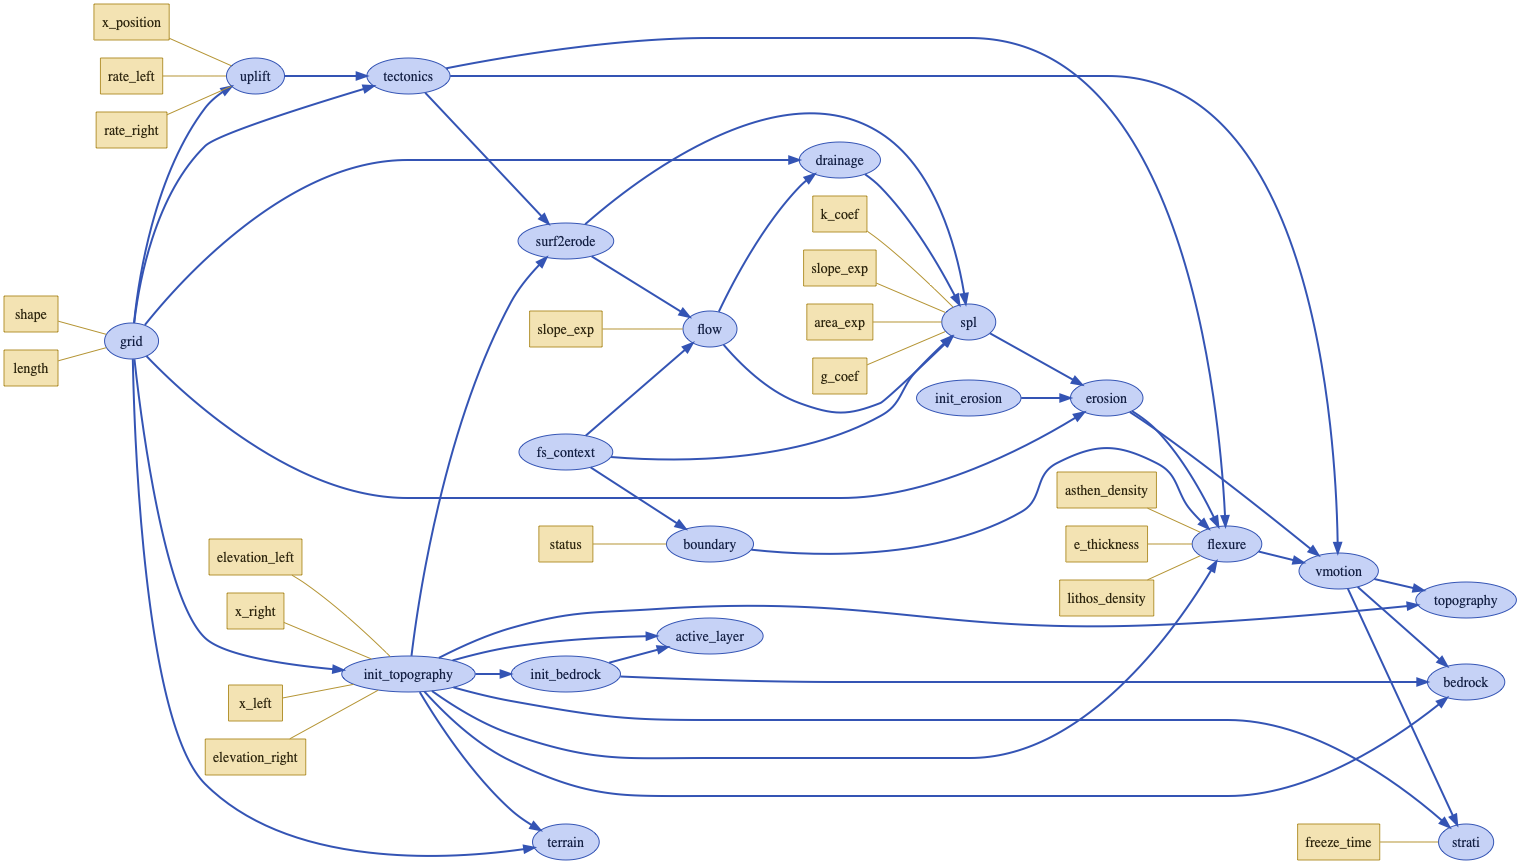

In [7]:
model.visualize(show_inputs=True)

## Model setup

In [8]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.arange(0, 1e7 + 2e4, 2e4),
        'out': np.arange(0, 1e7 + 2e5, 2e5),
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 401],
        'grid__length': [2e5, 4e5],
        'boundary__status': ['core', 'fixed_value', 'looped', 'looped'],
        'init_topography': {
            'x_left': 2e5,
            'x_right': 2e5,
            'elevation_left': 1e2,
            'elevation_right': 0.
        },
        'uplift': {
            'x_position': 2e5,
            'rate_left': 3e-4,
            'rate_right': 0.
        },
        'flow__slope_exp': 1.,
        'spl': {
            'k_coef': 1e-5,
            'g_coef': 1.,
        },
        'flexure': {
            'lithos_density': 2400.,
            'asthen_density': 3250.,
            'e_thickness': 1e4
        },
        'strati': {
            'freeze_time': np.linspace(0, 1e7, 5)
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'active_layer__thickness': 'out',
        'strati__elevation': 'out',
    }
)

in_ds

<xarray.Dataset>
Dimensions:                           (border: 4, horizon: 5, out: 51, shape_yx: 2, time: 501)
Coordinates:
  * time                              (time) float64 0.0 2e+04 ... 1e+07
  * out                               (out) float64 0.0 2e+05 ... 9.8e+06 1e+07
Dimensions without coordinates: border, horizon, shape_yx
Data variables:
    spl__slope_exp                    int64 1
    spl__area_exp                     float64 0.4
    grid__shape                       (shape_yx) int64 201 401
    grid__length                      (shape_yx) float64 2e+05 4e+05
    boundary__status                  (border) <U11 'core' ... 'looped'
    init_topography__x_left           float64 2e+05
    init_topography__x_right          float64 2e+05
    init_topography__elevation_left   float64 100.0
    init_topography__elevation_right  float64 0.0
    uplift__x_position                float64 2e+05
    uplift__rate_left                 float64 0.0003
    uplift__rate_right               

## Run the model


In [9]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

In [10]:
out_ds

<xarray.Dataset>
Dimensions:                           (border: 4, horizon: 5, out: 51, shape_yx: 2, time: 501, x: 401, y: 201)
Coordinates:
  * border                            (border) <U6 'left' 'right' 'top' 'bottom'
  * horizon                           (horizon) int64 0 1 2 3 4
  * out                               (out) float64 0.0 2e+05 ... 9.8e+06 1e+07
  * time                              (time) float64 0.0 2e+04 ... 1e+07
  * x                                 (x) float64 0.0 1e+03 ... 3.99e+05 4e+05
  * y                                 (y) float64 0.0 1e+03 ... 1.99e+05 2e+05
Dimensions without coordinates: shape_yx
Data variables:
    active_layer__thickness           (out, y, x) float64 0.0 0.0 ... 4.06 0.0
    boundary__status                  (border) <U11 'core' ... 'looped'
    flexure__asthen_density           float64 3.25e+03
    flexure__e_thickness              float64 1e+04
    flexure__lithos_density           float64 2.4e+03
    flow__slope_exp               

## Plot the outputs

In [11]:
import hvplot.xarray
import holoviews as hv
from xshade import hillshade


thickness_plot = out_ds.active_layer__thickness.hvplot.image(
    x='x', y='y', clim=(0, 600),
    cmap=plt.cm.viridis, groupby='out'
)

hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap=plt.cm.gray, alpha=0.5,
    colorbar=False, hover=False, groupby='out'
)

yhorizons_plot = out_ds.strati__elevation.sel(y=1e5).hvplot.line(
    by='horizon', groupby='out', ylim=(-2000, 2000),
    legend='top_right',
)

hv.Layout((thickness_plot * hillshade_plot) + yhorizons_plot).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Overlay
         .Image.I  :Image   [x,y]   (active_layer__thickness)
         .Image.II :Image   [x,y]   (hillshade)
   .DynamicMap.II :DynamicMap   [out]
      :NdOverlay   [horizon]
         :Curve   [x]   (strati__elevation)